# RSA on MEG data with MNE python

This is a modified version of [demo_meg_mne.ipynb](https://github.com/rsagroup/rsatoolbox/blob/main/demos/demo_meg_mne.ipynb) notebook from 
[rsatoolbox](https://rsatoolbox.readthedocs.io/en/stable/). 

This notebook demonstrates how to compute RDM movies from temporal data in MNE and identify significant temporal clusters of data-model RDM correlations.

### Steps:

1) load MNE epoched data (```mne.epochs.Epochs```)

    a) loading, downsampling, epoching, equalizing event count (*for the sake of reducing computation time, we provide preprocessed data, so this step can be skipped*)   
    b) simulate multiple subjects from single subject
    
2) import epoched data into rsatoolbox (```mne.epochs.Epochs```  $\rightarrow$ ```rsatoolbox.data.TemporalDataset```)
3) compute RDM movie (```rsatoolbox.data.TemporalDataset``` $\rightarrow$ ```rsatoolbox.rdm.rdms.RDMs```)
4) evaluate RDM movie similarity to model RDMs (```rsatoolbox.rdm.rdms.RDMs``` $\rightarrow$ ```rsatoolbox.inference.result.Result```)
5) compute cluster-based permutation statistic (```rsatoolbox.inference.result.Result``` $\rightarrow$ `mne.stats.permutation_cluster_1samp_test` $\rightarrow$ inference results)


In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

from os.path import exists
import rsatoolbox
from rsatoolbox.vis.timecourse import plot_timecourse

## 1. Load MNE epoched data

This step follows the first steps of [https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py](https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py)

### 1.1 Pre-processing (loading, downsampling, epoching, equalizing event counts)

In [2]:
# To keep computation time reasonable, we provide the preprocessed data directly
# so you don't have to run the preprocessing pipeline.
csv_fname = 'visual_stimuli.csv'
data_fname = 'visual_92_categories-epo.fif'
if exists(csv_fname) and exists(data_fname):
    conds = read_csv(csv_fname)
else:
    data_path = visual_92_categories.data_path()
    fname = data_path / 'visual_stimuli.csv'
    conds = read_csv(fname)

# Define stimulus - trigger mapping    
max_trigger = 93 # 93 all events, can be set lower number to reduce computation time
conds = conds[:max_trigger]  # take only the first max_trigger rows

conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))

print('condiiton names')
print(f'{str(conditions[:3])[:-1]}, \n... ,\n{str(conditions[-3:])[1:]}')

event_id = dict(zip(conditions, conds.trigger + 1))

condiiton names
['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', 
... ,
'89/artificial inanimate/not-human/not-face/not-animal/not-natural', '90/artificial inanimate/not-human/not-face/not-animal/not-natural', '91/artificial inanimate/not-human/not-face/not-animal/not-natural']


In [3]:
# To keep computation time reasonable, we provide the preprocessed data directly
# so you don't have to run the preprocessing pipeline.
if exists(csv_fname):
    epochs = mne.read_epochs('visual_92_categories-epo.fif')
else:
    n_runs = 4  # 4 for full data (use less to speed up computations)
    fnames = [data_path / f'sample_subject_{b}_tsss_mc.fif' for b in range(n_runs)]
    raws = [read_raw_fif(fname, verbose='error', on_split_missing='ignore')
            for fname in fnames]  # ignore filename warnings
    raw = concatenate_raws(raws, preload=True)
    
    # downsample data to ~ 100Hz
    current_sfreq = raw.info['sfreq']
    desired_sfreq = 100  # Hz
    decim = np.round(current_sfreq / desired_sfreq).astype(int)
    obtained_sfreq = current_sfreq / decim
    lowpass_freq = obtained_sfreq / 3.
    
    raw_filtered = raw.copy().filter(l_freq=None, h_freq=lowpass_freq)
    
    # create epoched data 
    events = mne.find_events(raw, min_duration=.002)
    events = events[events[:, 2] <= max_trigger]
    picks = mne.pick_types(raw.info, meg=True)
    epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                        picks=picks, tmin=-.1, tmax=.500, preload=True,
                        decim=decim)


Reading .../COGNESTIC/10_MVPA_EEG_MEG/RSA/visual_92_categories-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2758 matching events found
No baseline correction applied
0 projection items activated


Plot evoked data for inspection

No projector specified for this dataset. Please consider the method self.add_proj.


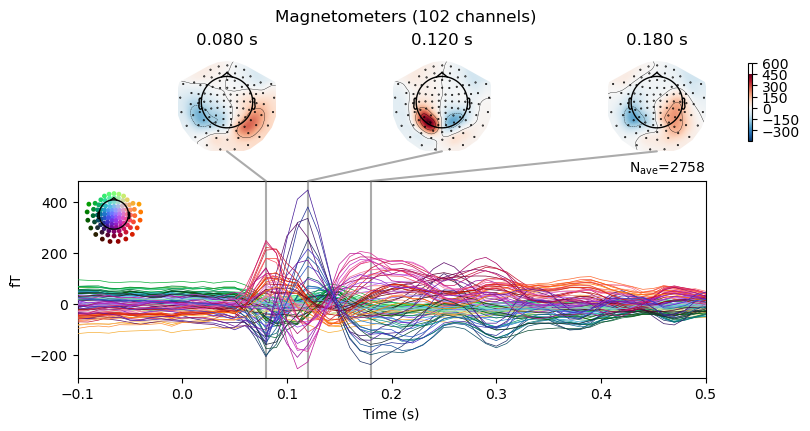

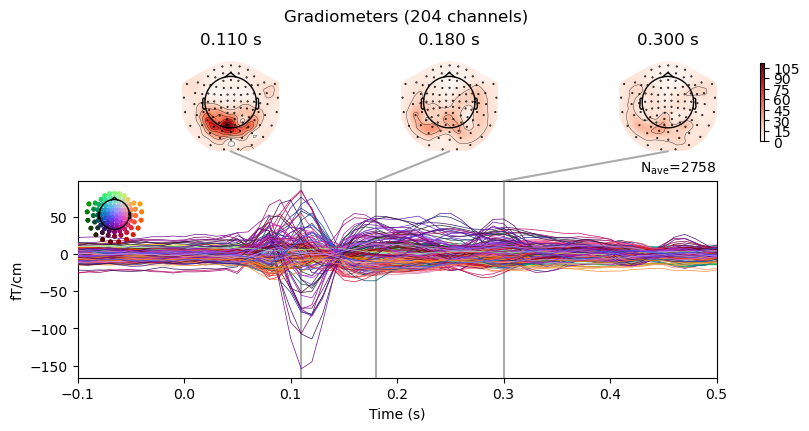

In [4]:
_ = epochs.average().plot_joint()

We need to equalize event counts in order to make use of the default crossvalidation scheme in rsatoolbox for the crossnobis calculations. Alternatively, we could also devise another crossvalidation scheme for which we might choose not to equalize event count.

In [5]:
epochs.equalize_event_counts()

Dropped 90 epochs: 930, 1478, 1479, 1480, 1481, 1482, 1486, 1492, 1493, 1499, 1504, 1505, 1518, 1520, 1521, 1525, 1539, 1657, 1659, 1669, 1709, 1713, 1730, 1742, 1743, 1745, 1749, 1752, 1754, 1757, 1758, 1761, 1763, 1768, 1770, 1771, 1772, 1774, 1777, 1778, 1779, 1780, 1781, 1782, 1784, 1785, 1787, 1788, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1798, 1800, 1803, 1805, 1806, 1807, 1808, 1810, 1812, 1814, 1815, 1817, 1818, 1819, 1820, 1821, 1823, 1824, 1825, 1826, 1827, 1830, 1831, 1832, 1833, 1836, 1837, 1838, 1946, 1959, 2001, 2007, 2011, 2013, 2016


(<EpochsFIF | 2668 events (all good), -0.1 – 0.5 s (baseline off), ~386.3 MiB, data loaded,
  '0/human bodypart/human/not-face/animal/natural': 29
  '1/human bodypart/human/not-face/animal/natural': 29
  '2/human bodypart/human/not-face/animal/natural': 29
  '3/human bodypart/human/not-face/animal/natural': 29
  '4/human bodypart/human/not-face/animal/natural': 29
  '5/human bodypart/human/not-face/animal/natural': 29
  '6/human bodypart/human/not-face/animal/natural': 29
  '7/human bodypart/human/not-face/animal/natural': 29
  '8/human bodypart/human/not-face/animal/natural': 29
  '9/human bodypart/human/not-face/animal/natural': 29
  and 82 more events ...>,
 array([1823, 1493, 1713, 1780, 1774, 1768, 1832, 1742, 1777, 1521,  930,
        1492, 1525, 1795, 1758, 1657, 1791, 1831, 1810, 1819, 1808, 1730,
        1803, 1763, 2007, 1821, 1479, 1520, 1778, 1782, 1504, 1781, 1787,
        1824, 1499, 2011, 1478, 1793, 1820, 1784, 1798, 2013, 1757, 1749,
        1827, 1669, 1814, 1743, 174

In [6]:
# only using magnetometers for this example
picks = ['mag']

# dimension labels
ch_names = [ch_name for ch_name, ch_type in zip(epochs.ch_names, epochs.get_channel_types()) if ch_type in picks]
event_ids = epochs.event_id
times = epochs.times

n_events, n_channels, n_times = epochs.get_data(picks=picks).shape

# get condition name per event
rev_event_id = {v: k for k, v in epochs.event_id.items()}
event_names = np.array([rev_event_id[i] for i in epochs.events[:, 2]])

### 1.2 Simulate multiple subjects

We will simulate multiple subjects as noisy versions of the one subject

1) We will first compute the noise precision matrix and the condition averages for one subject
2) We then create simulated subjects

#### 1.2.1 Compute channel noise precision matrix for single subject

compute residuals by subtracting repition-averaged timecourses

In [7]:
residuals = np.zeros_like(epochs.get_data(picks=picks))

# loop over event_id and compute residuals
for event_id, trigger in epochs.event_id.items():
    events_data = epochs[event_id].get_data(picks=picks) # n_repetitions x n_channels x n_times    
    residuals[event_id == event_names, :, :] = events_data - np.mean(events_data, axis=0, keepdims=True)

print(f'{residuals.shape=} = (n_events, n_channels, n_timepoints)')

residuals.shape=(2668, 102, 61) = (n_events, n_channels, n_timepoints)


compute precision matrix - we collapse timepoints and events into one dimension

In [8]:
reshaped_residuals = np.swapaxes(residuals, 1, 2).reshape(-1, n_channels)
print(f'{reshaped_residuals.shape=} = (n_events * n_timepoints, n_channels)')

prec = rsatoolbox.data.prec_from_residuals(reshaped_residuals, method='shrinkage_diag')
print(f'{prec.shape=} = (n_channels, n_channels)')

reshaped_residuals.shape=(162748, 102) = (n_events * n_timepoints, n_channels)
prec.shape=(102, 102) = (n_channels, n_channels)


#### 1.2.2 Compute condition averages for single subject

In [9]:
averaged_epochs = np.zeros((len(epochs.event_id), n_channels, len(epochs.times)))

for ii,(event_id, trigger) in enumerate(epochs.event_id.items()):
    averaged_epochs[ii, :, :] = epochs[event_id].average().get_data(picks=picks)

print(f'{averaged_epochs.shape=} = (n_conditions, n_channels, n_timepoints)')

averaged_epochs.shape=(92, 102, 61) = (n_conditions, n_channels, n_timepoints)


#### 1.2.3 Simulate multiple subjects

In [10]:
n_subjects = 7
noise = .1 # as multiple of np.std(averaged_epochs)

In [11]:
data_sd = averaged_epochs.std()
group_data = [epochs.get_data(picks=picks) + np.random.randn(*epochs.get_data(picks=picks).shape) * noise * data_sd for _ in range(n_subjects)]
print(f'{len(group_data)=} = (n_subjects) each element is a {group_data[0].shape=} = (n_conditions, n_channels, n_timepoints)')

# we'll just use the same precision noise matrix for all subjects for this example
group_prec_matrix = [prec] * n_subjects
print(f'\n{len(group_prec_matrix)=} = (n_subjects), each element is a {group_prec_matrix[0].shape=} = (n_channels, n_channels) matrix')

len(group_data)=7 = (n_subjects) each element is a group_data[0].shape=(2668, 102, 61) = (n_conditions, n_channels, n_timepoints)

len(group_prec_matrix)=7 = (n_subjects), each element is a group_prec_matrix[0].shape=(102, 102) = (n_channels, n_channels) matrix


## 2. Import data into rsatoolbox

We import the individual trials (not the averaged evoked responses) into the RSA toolbox here. This is because we compute the crossvalidated mahalanobis distance which requires crossvalidation that relies on individual trials.

In [12]:
# parse the factor levels
image_index = np.array([int(event_name.split('/')[0]) for event_name in event_names])
condition = np.array([event_name.split('/')[1] for event_name in event_names])
human = np.array([event_name.split('/')[2] for event_name in event_names])
face = np.array([event_name.split('/')[3] for event_name in event_names])
animal = np.array([event_name.split('/')[4] for event_name in event_names])
natural = np.array([event_name.split('/')[5] for event_name in event_names])

In [13]:
des = {'session': 0}                        # some (made up) metadata, we could also append data session-wise and crossvalidate across sessions ...
                                            # ... but we'll just pretend all data came from one session and crossvalidate across image category repetitions

obs_des = dict(                             # observation descriptors
                image_index=image_index,    # image index
                condition=condition,        # image category
                human=human,                # human vs not-human
                face=face,                  # face vs not-face
                animal=animal,              # animal vs not-animal
                natural=natural             # natural vs not-natural
                )

chn_des = {'channels': ch_names}            # channel descriptors

tim_des = {'time': times}                   # time descriptor


data = []
for i, subject_data in enumerate(group_data):
    des['subject'] = i
    data.append(rsatoolbox.data.TemporalDataset(subject_data,
                                descriptors = des,
                                obs_descriptors = obs_des,
                                channel_descriptors = chn_des,
                                time_descriptors = tim_des))
    data[-1].sort_by('image_index')

## 3. Compute RDM movie

In [14]:
descriptor = 'image_index'
rdms_data = rsatoolbox.rdm.calc_rdm_movie(
    data, # list of length n_subjects
    method = 'crossnobis',
    descriptor = descriptor,
    noise = group_prec_matrix # list of len(data)
)
print(rdms_data.dissimilarities.shape)
print(f'{rdms_data.dissimilarities.shape=} = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)')

(427, 4186)
rdms_data.dissimilarities.shape=(427, 4186) = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)


Let's plot the RDM movie timecourse. We can use the `plot_timecourse` function to visualize this. Each line in the plot below represents to the dissimilarity value for a pair of conditions across time. The x-axis represents time, and the y-axis represents the dissimilarity value. The function alos plots the RDM matrices at a few time points to illustrate how the dissimilarity structure changes over time.

.../.conda/envs/cognestic25_mne/lib/python3.12/site-packages/rsatoolbox/vis/timecourse.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  tc_ax.legend()


Text(0.5, 1.0, 'data RDM movie and individual dissimilarity trajectories')

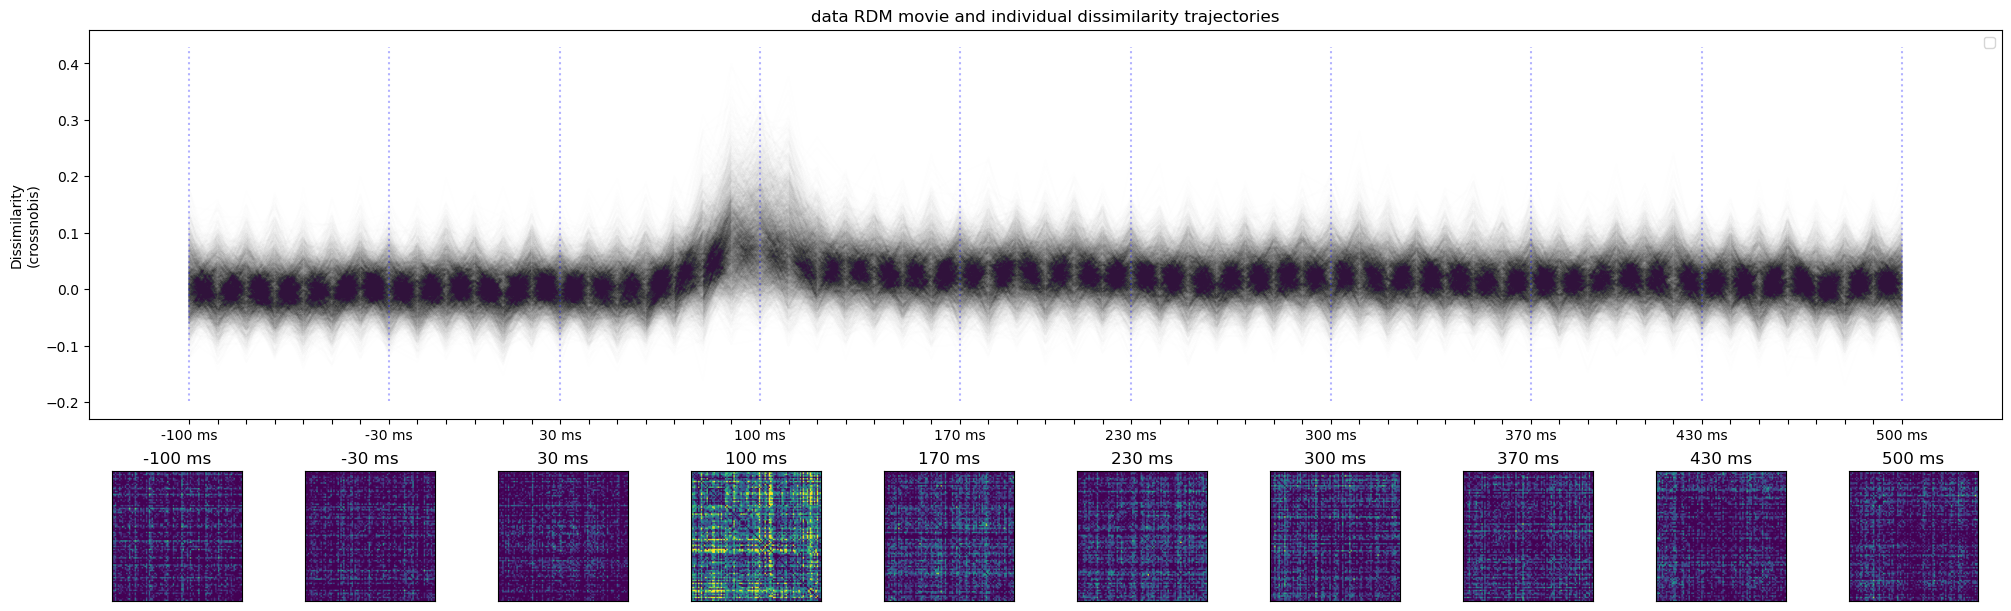

In [ ]:
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=None,
)
ax[0].set_title('data RDM movie and individual dissimilarity trajectories')

By setting the `colored_conditions` argument it is possible to average over dissimilarity values that are within or outside of the colored conditions and plot their values separately. Below we set the `colored_conditions` argument to the face-ness and the resulting plot shows average dissimilarity values for fase vs. face, face vs. non-face, and non-face vs. non-face conditions separately. 

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by face/not-face')

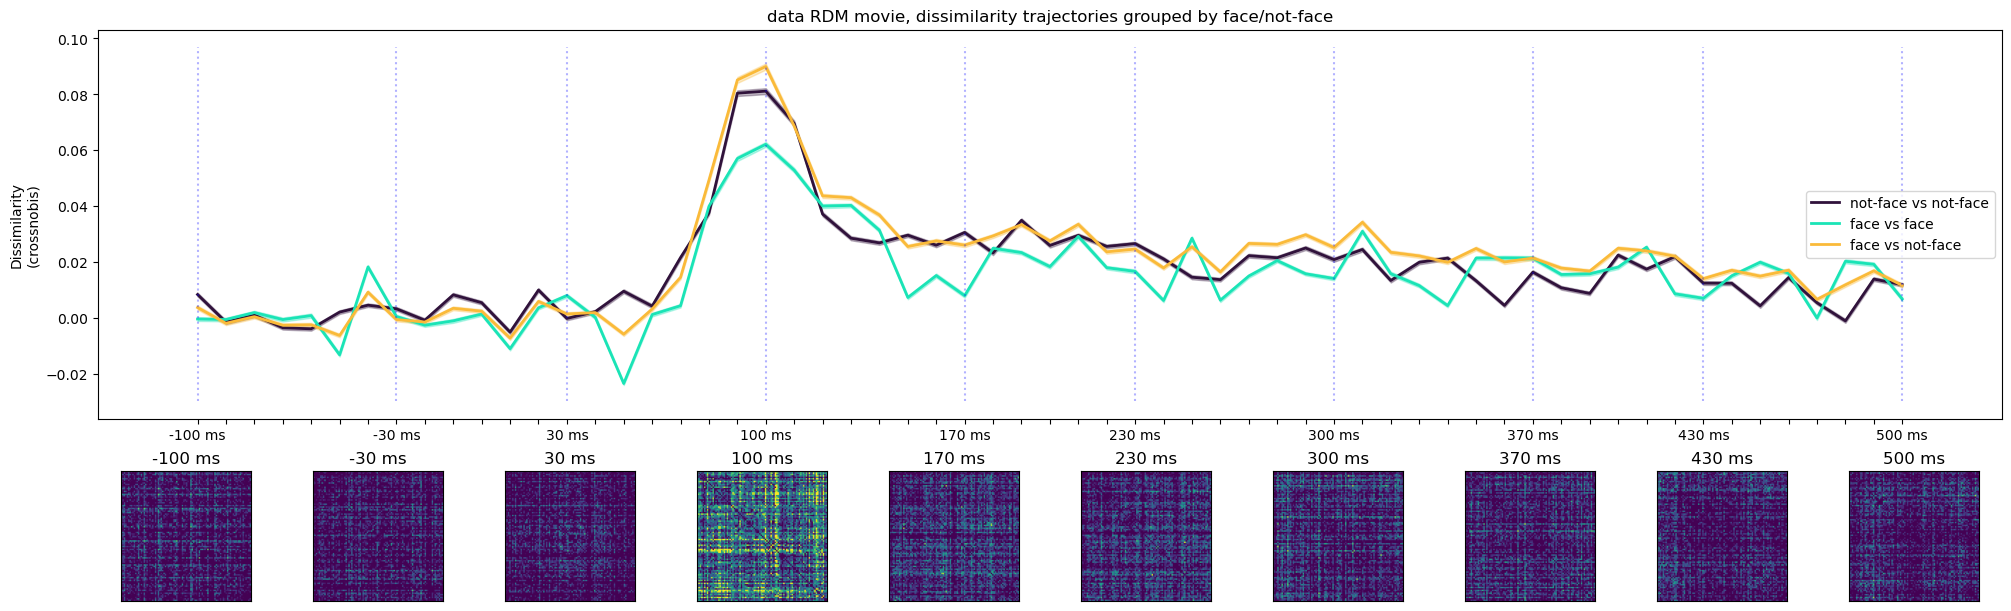

In [16]:
face = np.array([event_name.split('/')[3] for event_name in conditions])
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=face
);
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by face/not-face')

Below is the same just for natural-ness.

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

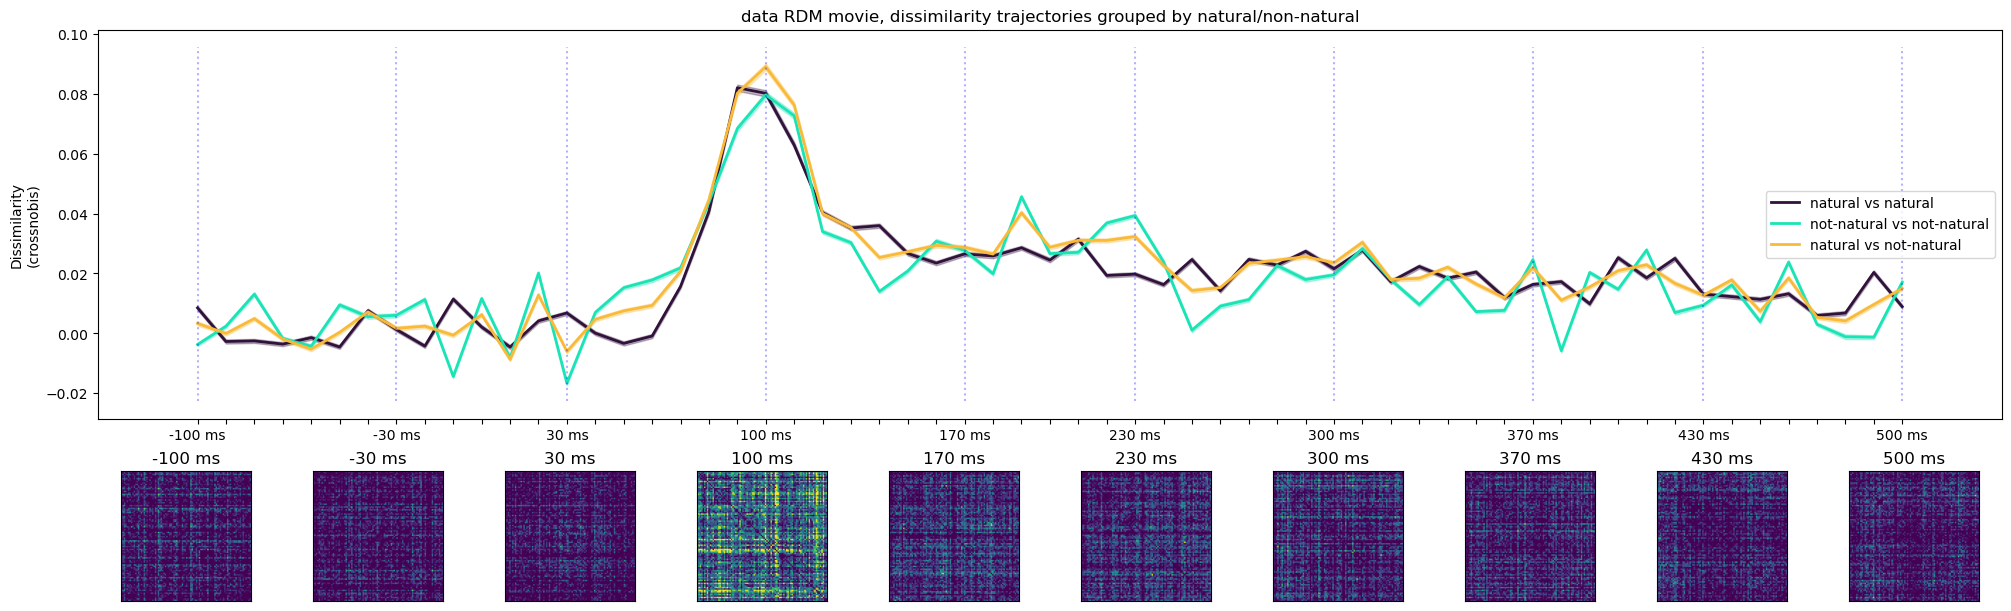

In [17]:
natural = np.array([event_name.split('/')[5] for event_name in conditions])
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=natural
);
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

## 4. Evaluate RDM movie similarity to model RDMs

In [18]:
image_index = np.array([int(event_name.split('/')[0]) for event_name in conditions])
condition = np.array([event_name.split('/')[1] for event_name in conditions])
human = np.array([event_name.split('/')[2] for event_name in conditions])
face = np.array([event_name.split('/')[3] for event_name in conditions])
animal = np.array([event_name.split('/')[4] for event_name in conditions])
natural = np.array([event_name.split('/')[5] for event_name in conditions])

For this example, we'll just look at two model RDMs.
- A categorical RDM that encodes face-ness
- A categorical RDM that encodes natural-ness

In [19]:
# First create the model RDM for face/not-face
face_notface_rdm = rsatoolbox.rdm.get_categorical_rdm(
    [1 if i=='face' else 0 for i in face],
    'face_notface')
# Then a fixed model is created from the RDM
face_notface_model = rsatoolbox.model.ModelFixed(
    'face_notface',
    face_notface_rdm)

# Do the same for natural/not-natural
natural_notnatural_rdm = rsatoolbox.rdm.get_categorical_rdm(
    [1 if i=='natural' else 0 for i in natural], 
    'natural_notnatural')
natural_notnatural_model = rsatoolbox.model.ModelFixed(
    'natural_notnatural',
    natural_notnatural_rdm)

Let's display the two model RDMs

(<Figure size 200x200 with 1 Axes>,
 array([[<Axes: >]], dtype=object),
 {-1: {}, 0: {'image': <matplotlib.image.AxesImage at 0x732b1b5768d0>}})

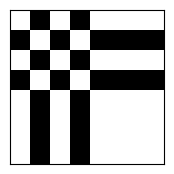

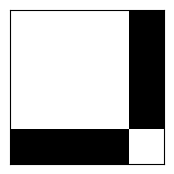

In [20]:
rsatoolbox.vis.show_rdm(face_notface_rdm)
rsatoolbox.vis.show_rdm(natural_notnatural_rdm)

In [21]:
# Pack models and model names into lists
model_names = ['face_notface', 'natural_notnatural']
models = [face_notface_model, natural_notnatural_model]

We chose cosine similarity for the crossnobis-RDMs

In [22]:
results = rsatoolbox.inference.eval_fixed(models, rdms_data, method='cosine')
print(f'{results.evaluations.shape=} = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)')

results.evaluations.shape=(1, 2, 427) = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)


## 5. Compute cluster-based permutation statistic


Timepoints and subjects are packed into the last dimension of `results.evaluations`

The util function `num_index()` together with the `rdm_descriptors` from the `rdms_data` will help us indexing the correct elements

In [23]:
from rsatoolbox.util.descriptor_utils import num_index
print(f'{rdms_data.rdm_descriptors.keys() = }')

# get indices for the first timepoint in the last dimension of results.evaluations
print(f'\n{num_index(rdms_data.rdm_descriptors["time"], times[0]) = }')

# we reshape the evaluations to get a (n_models, n_subjects, n_timepoints) array
evaluations_reshaped = np.concatenate(
    [results.evaluations[0][:, num_index(rdms_data.rdm_descriptors['time'], time)][:, :, np.newaxis] 
        for time in np.unique(times)],
    axis=2
)
print(f'\n{evaluations_reshaped.shape = }')

rdms_data.rdm_descriptors.keys() = dict_keys(['session', 'subject', 'index', 'time'])

num_index(rdms_data.rdm_descriptors["time"], times[0]) = array([  0,  61, 122, 183, 244, 305, 366])

evaluations_reshaped.shape = (2, 7, 61)


Plot the timecourse of similarity scores between the observed RDM movie and the model RDMs, separately for each model, across simulated subjects. The shaded area represents the standard error of the mean across simulated subjects. 

evaluations_mean.shape=(2, 61)
evaluations_sem.shape=(2, 61)


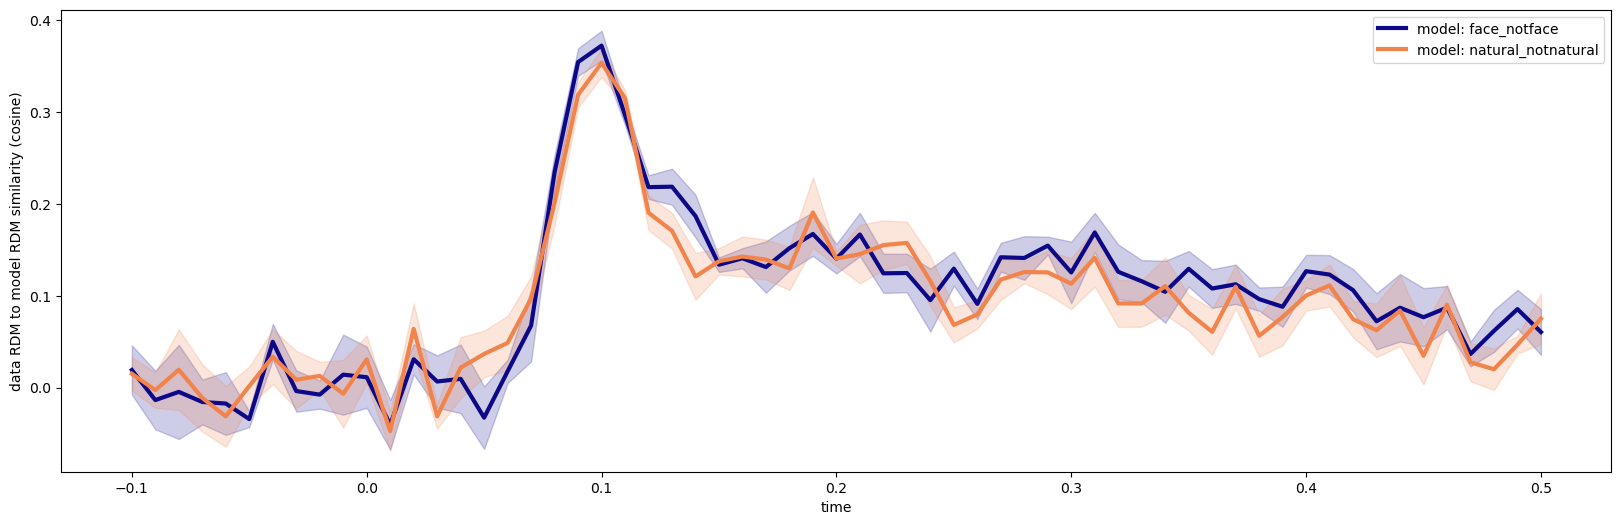

In [24]:
# mean and sem across subjects
evaluations_mean = np.mean(evaluations_reshaped, axis=1).squeeze()
evaluations_sem = np.std(evaluations_reshaped, axis=1).squeeze() / np.sqrt(evaluations_reshaped.shape[1])

print(f'{evaluations_mean.shape=}')
print(f'{evaluations_sem.shape=}')

fig, ax = plt.subplots(1,1, figsize=(20,6))
colors = plt.get_cmap('plasma')(np.linspace(0., .7, len(model_names)))
for i, (ev,sem) in enumerate(zip(evaluations_mean, evaluations_sem)):
    ax.fill_between(np.unique(times), ev-sem, ev+sem, color=colors[i], alpha=.2)
    ax.plot(np.unique(times), ev, color=colors[i], label=f"model: {model_names[i]}", linewidth=3)
ax.legend()
ax.set_ylabel('data RDM to model RDM similarity (cosine)')
ax.set_xlabel('time')
plt.show()

Define auxiliary functions to plot statistics results for individual models and their contrast

In [25]:
def plot_contrast_stats(data, statistic, clusters, cluster_p_values, H0, model_names):
        
    T = np.unique(times)
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    
    mn, se = data[0].mean(axis=0)-data[1].mean(axis=0), (data[0]-data[1]).std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, 
            label=f"{model_names[0]} vs {model_names[1]}")
        
    ax.set_ylabel("difference in data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax2.plot(T, statistic, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")
    
    return fig, (ax, ax2)
    
def plot_condition_stats(data, statistic, clusters, cluster_p_values, H0, model_name, axes=None):
        
    T = np.unique(times)
    if axes is None:
        fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    else:
        ax, ax2 = axes
        fig = ax.get_figure()
    
    mn, se = data.mean(axis=0), data.std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, label=f"{model_name}")
    ax.set_ylabel("data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax2.plot(T, statistic, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")    
    return fig, (ax, ax2)

Compute permutation statistics for the contrast between the two models and plot the results 

stat_fun(H1): min=1.0391415366447545e-05 max=4.500075916578489
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'face_notface vs natural_notnatural')

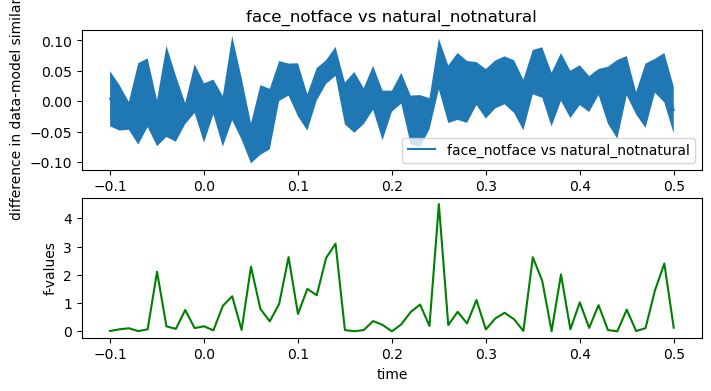

In [26]:
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(list(evaluations_reshaped), threshold=.05)

fig, ax = plot_contrast_stats(evaluations_reshaped, F_obs, clusters, cluster_p_values, H0, model_names)
ax[0].set_title(f'{model_names[0]} vs {model_names[1]}')

Compute the cluster-based permutation statistic for the individual models and plot the results

stat_fun(H1): min=-3.6755696500322794 max=24.853529318137536
Running initial clustering …
Found 9 clusters


  0%|          | Permuting (exact test) : 0/63 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.155085747275446 max=34.556738838598996
Running initial clustering …
Found 11 clusters


  0%|          | Permuting (exact test) : 0/63 [00:00<?,       ?it/s]

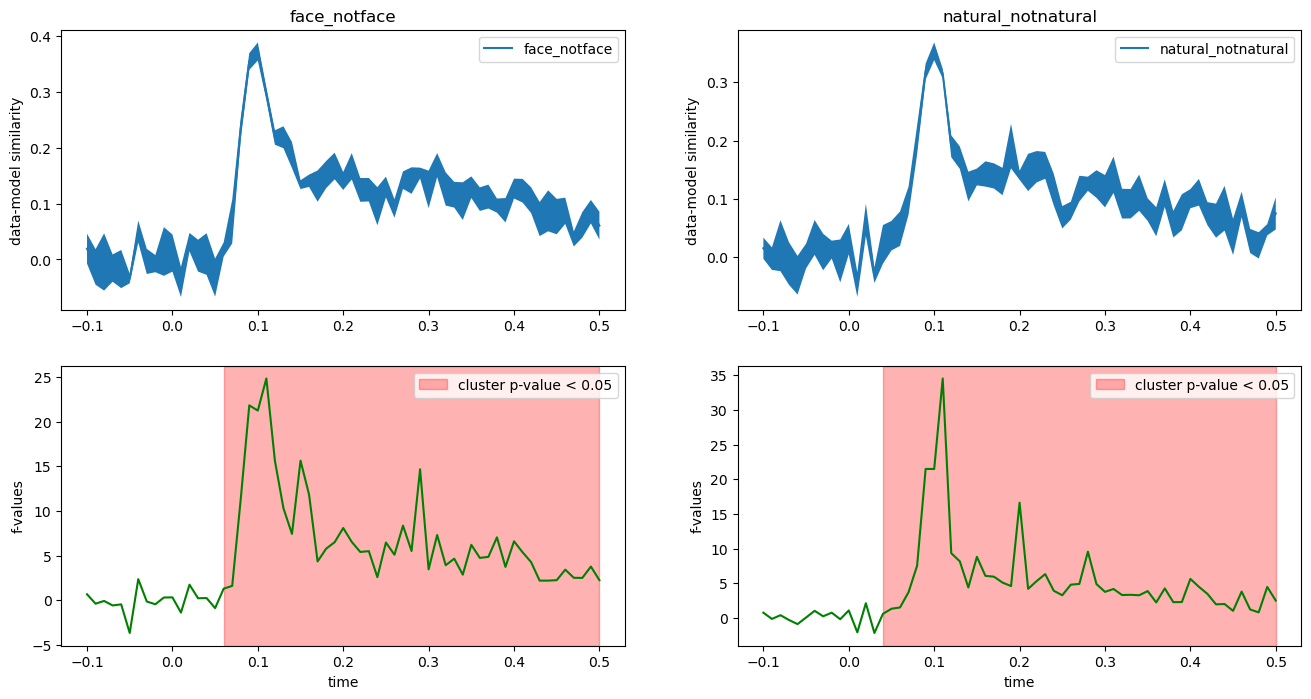

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for model_name, data, ax in zip(model_names, evaluations_reshaped, axes.T):
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(data, threshold=.05)
    plot_condition_stats(data, T_obs, clusters, cluster_p_values, H0, model_name, axes=ax)
    ax[0].set_title(model_name)

## 6. Exercises
Evaluate a model that expresses the animal-ness (or animacy) of the objects (i.e. animal vs. non-animal)
  - plot the RDM movie grouped by animal-ness
  - Make the model RDM and the fixed model for animal-ness and plot them
  - Evaluate the animal-ness model
  - Contrast with the other models